<a href="https://colab.research.google.com/github/Kamilmerito/Projets-ML/blob/main/formationcustomerchurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Objectif: prédire si un client va se desabonner ou pas*

**Importation de librairies**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.model_selection import  train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE

In [ ]:
#importation de données
df=pd.read_csv("https://raw.githubusercontent.com/JosueAfouda/TUTORIALS/main/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


la variable cible: ***Churn***

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [ ]:
categorical_columns=df.nunique()[df.nunique()<5].keys().to_list()
categorical_columns

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [ ]:
def bar_plot(a):
  df[a].value_counts(normalize=True).plot(kind="bar")
  plt.ylabel("Proportion")
  plt.title("Distribution of "+str(a))
  return plt.show()


In [ ]:
#interact
interact(bar_plot, a=categorical_columns)

interactive(children=(Dropdown(description='a', options=('gender', 'SeniorCitizen', 'Partner', 'Dependents', '…

<function __main__.bar_plot>

*Il y a 70% des clients qui ne se sont pas desabonnés( contre 30%). Nous avons un problème déséquilibre qu'il faudra absolument résoudre  car cela peut impacter la performace  des modèles de classification  que nous allons construire.*

*La distribution de données entre  différents sexes est à peu près également repartie.*

*Le nombre de clients agés est très faible (20%)*

*La variable partner (No or yes). Les 2 catégories ont la proportion*

In [ ]:
#numerical_columns=df.drop(columns=categorical_columns,axis=1)
#numerical_columns=numerical_columns.nunique()[df.nunique()>72].keys().to_list()

In [ ]:
numerical_columns=['tenure','MonthlyCharges','TotalCharges']

In [ ]:
df[numerical_columns]

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.5
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65
...,...,...,...
7038,24,84.80,1990.5
7039,72,103.20,7362.9
7040,11,29.60,346.45
7041,4,74.40,306.6


In [ ]:
df['customerID']

0       7590-VHVEG
1       5575-GNVDE
2       3668-QPYBK
3       7795-CFOCW
4       9237-HQITU
           ...    
7038    6840-RESVB
7039    2234-XADUH
7040    4801-JZAZL
7041    8361-LTMKD
7042    3186-AJIEK
Name: customerID, Length: 7043, dtype: object

In [ ]:
#échantillonement aléatoire
df["TotalCharges"].sample(10)

6154    7711.45
2172      43.95
2981    1430.95
5903     4627.8
2572       1753
871        5598
4016      45.35
1486     102.75
1898      378.4
3828    1319.95
Name: TotalCharges, dtype: object

*Apparemment à cause d'espace au niveau de la variable totalcharges que pandas la considère de type object.*

In [ ]:
#création d'une fonction de construction d'histogramme  et de manière interative
def hist_plot(b):
  sns.displot(df[b],kde=False)
  plt.title("Histogram of"+str(b))
  return plt.show()

In [ ]:
#conversion en float de la variable "TotalCharges"
df["TotalCharges"]=df["TotalCharges"].replace(' ', np.nan).astype("float")

In [ ]:
#interact

interact(hist_plot, b=numerical_columns);

interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

In [ ]:
#coefficient d'asymétrie
df["TotalCharges"].skew()

0.961642499724251

In [ ]:
#Création d'une fonction de construction de boites à moutaches et de manière interactive
def box_plot(b):
  sns.boxplot(y=df[b])
  plt.title("Boxplot of "+str(b))
  return plt.show()

In [ ]:
#interact
interact(box_plot, b=numerical_columns)

interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

<function __main__.box_plot>

*Nous remarquons que ces variables ne présentent pas des valeurs aberrantes mais elles sont asymétriques cela peut créer des erreurs pour les modèles. Nous devons faire des transformations sur ces variables pour les rendre mois asymétriques.*

Text(0.5, 1.0, 'Montant total facturé aux clients')

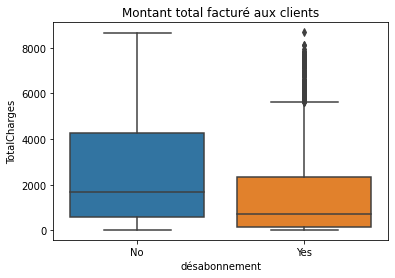

In [ ]:
#analyse bivariée
#TotalCharges vs Churn

sns.boxplot(x="Churn", y="TotalCharges", data=df)
plt.xlabel("désabonnement")
plt.ylabel("TotalCharges")
plt.title("Montant total facturé aux clients")

Text(0.5, 1.0, 'Montant total facturé aux clients par mois')

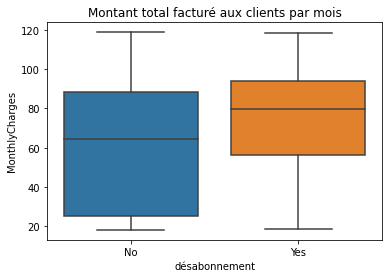

In [ ]:
#analyse bivariée
# Churn vs MonthlyCharges

sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.xlabel("désabonnement")
plt.ylabel("MonthlyCharges")
plt.title("Montant total facturé aux clients par mois")

Text(0.5, 1.0, 'Clients fidèles ')

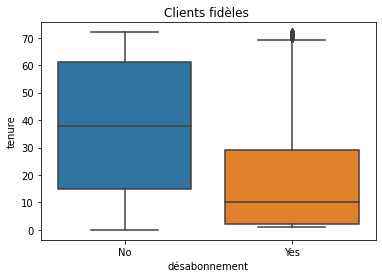

In [ ]:
#analyse bivariée
# Churn vs tenure

sns.boxplot(x="Churn", y="tenure", data=df)
plt.xlabel("désabonnement")
plt.ylabel("tenure")
plt.title("Clients fidèles ")

Text(0.5, 1.0, "clientsfidèles selon l'âge")

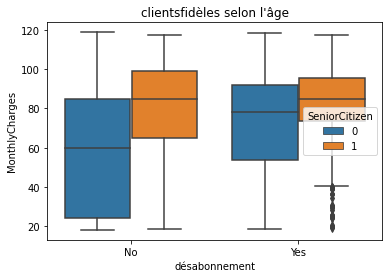

In [ ]:
#analyse bivariée
# Churn vs MonthlyCharges by Seniorcitizen

sns.boxplot(x="Churn", y="MonthlyCharges", data=df,hue="SeniorCitizen")
plt.xlabel("désabonnement")
plt.ylabel("MonthlyCharges")
plt.title("clientsfidèles selon l'âge")

Text(0.5, 1.0, 'Montantfacturé aux clients ayant des charges par mois')

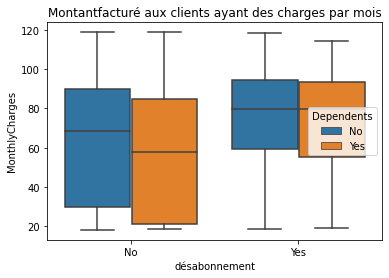

In [ ]:
#analyse bivariée
# Churn vs MonthlyCharges by Dependant

sns.boxplot(x="Churn", y="MonthlyCharges", data=df, hue="Dependents")
plt.xlabel("désabonnement")
plt.ylabel("MonthlyCharges")
plt.title("Montantfacturé aux clients ayant des charges par mois")

In [ ]:
#statisttique

df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


**Pré-traitement**

In [ ]:
data=df.copy()
data
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
#suppression des valeurs manquantes
data.dropna(inplace=True)

In [ ]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
data[categorical_columns]

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No
7039,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No
7040,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
7041,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes


In [ ]:
#encodage des variables binaires
data["gender"]=data["gender"].apply(lambda row: 1 if row=="female" else 0)
data["gender"]

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Name: gender, Length: 7032, dtype: int64

In [ ]:
data[categorical_columns].drop("gender",axis=1)

,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No
7039,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No
7040,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
7041,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes


In [ ]:
categorical_columns

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [ ]:
binary_columns=data[categorical_columns].drop("gender",axis=1).nunique()[data[categorical_columns].drop("gender",axis=1).nunique()==2].keys().to_list()
binary_columns

['SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [ ]:
for column in binary_columns:
  data[column]=data[column].apply(lambda row: 1 if row=="Yes" else 0)

In [ ]:
data[binary_columns]

,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,0,1,0,0,1,0
1,0,0,0,1,0,0
2,0,0,0,1,1,1
3,0,0,0,0,0,0
4,0,0,0,1,1,1
...,...,...,...,...,...,...
7038,0,1,1,1,1,0
7039,0,1,1,1,1,0
7040,0,1,1,0,1,0
7041,0,1,0,1,1,1


In [ ]:
#variables catégorielles restantes
remaining=data[categorical_columns].drop("gender",axis=1).nunique()[data[categorical_columns].drop("gender",axis=1).nunique()>2].keys().to_list()
remaining


['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [ ]:
data[remaining]
remaining_dummies=pd.get_dummies(data[remaining],columns=remaining,drop_first=True)

In [ ]:
#code
customer=data["customerID"]
customer

0       7590-VHVEG
1       5575-GNVDE
2       3668-QPYBK
3       7795-CFOCW
4       9237-HQITU
           ...    
7038    6840-RESVB
7039    2234-XADUH
7040    4801-JZAZL
7041    8361-LTMKD
7042    3186-AJIEK
Name: customerID, Length: 7032, dtype: object

In [ ]:
customer_dummies=pd.get_dummies(data["customerID"],columns=customer,drop_first=True)
customer_dummies

,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ,0013-MHZWF,0013-SMEOE,0014-BMAQU,0015-UOCOJ,0016-QLJIS,0017-DINOC,0017-IUDMW,0018-NYROU,0019-EFAEP,0019-GFNTW,0020-INWCK,0020-JDNXP,0021-IKXGC,0022-TCJCI,0023-HGHWL,0023-UYUPN,0023-XUOPT,0027-KWYKW,0030-FNXPP,0031-PVLZI,0032-PGELS,0036-IHMOT,0040-HALCW,0042-JVWOJ,0042-RLHYP,0048-LUMLS,0048-PIHNL,0052-DCKON,0052-YNYOT,0056-EPFBG,0057-QBUQH,0058-EVZWM,0060-FUALY,0064-SUDOG,0064-YIJGF,0067-DKWBL,...,9938-PRCVK,9938-TKDGL,9938-ZREHM,9940-HPQPG,9940-RHLFB,9943-VSZUV,9944-AEXBM,9944-HKVVB,9945-PSVIP,9947-OTFQU,9948-YPTDG,9950-MTGYX,9953-ZMKSM,9955-QOPOY,9957-YODKZ,9958-MEKUC,9959-WOFKT,9961-JBNMK,9962-BFPDU,9964-WBQDJ,9965-YOKZB,9967-ATRFS,9968-FFVVH,9970-QBCDA,9971-ZWPBF,9972-EWRJS,9972-NKTFD,9972-VAFJJ,9974-JFBHQ,9975-GPKZU,9975-SKRNR,9978-HYCIN,9979-RGMZT,9985-MWVIX,9986-BONCE,9987-LUTYD,9992-RRAMN,9992-UJOEL,9993-LHIEB,9995-HOTOH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7039,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7041,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#nouvelle dataframe
data=pd.concat([data["gender"],data[binary_columns],remaining_dummies,data[numerical_columns],customer_dummies],axis=1)

In [ ]:
#affichage de nouvelle dataframe
data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ,0013-MHZWF,0013-SMEOE,0014-BMAQU,0015-UOCOJ,0016-QLJIS,...,9938-PRCVK,9938-TKDGL,9938-ZREHM,9940-HPQPG,9940-RHLFB,9943-VSZUV,9944-AEXBM,9944-HKVVB,9945-PSVIP,9947-OTFQU,9948-YPTDG,9950-MTGYX,9953-ZMKSM,9955-QOPOY,9957-YODKZ,9958-MEKUC,9959-WOFKT,9961-JBNMK,9962-BFPDU,9964-WBQDJ,9965-YOKZB,9967-ATRFS,9968-FFVVH,9970-QBCDA,9971-ZWPBF,9972-EWRJS,9972-NKTFD,9972-VAFJJ,9974-JFBHQ,9975-GPKZU,9975-SKRNR,9978-HYCIN,9979-RGMZT,9985-MWVIX,9986-BONCE,9987-LUTYD,9992-RRAMN,9992-UJOEL,9993-LHIEB,9995-HOTOH
0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,29.85,29.85,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,34,56.95,1889.50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,53.85,108.15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,45,42.30,1840.75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,70.70,151.65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.shape

(7032, 7062)

In [ ]:
#transformation de la variable "totalCharges"
data["TotalCharges"]=np.sqrt(data["TotalCharges"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


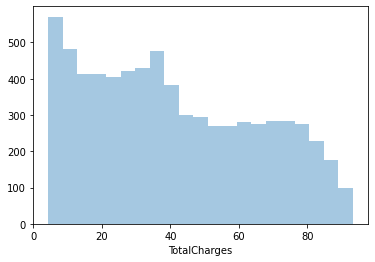

In [ ]:
#historgramme de la variable transformée

sns.distplot(data["TotalCharges"],kde=False)

In [ ]:
#coef d'asymétrie
data["TotalCharges"].skew()

0.3089261418986736

**Données d'entrainement (60%, validation 20%,test 20%)**

In [ ]:
X=data.drop(["Churn"],axis=1)
y=data["Churn"]
seed=1111
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4, random_state=1111,stratify=y)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5, random_state=1111,stratify=y_test)


*IL faut s'assurer que les données ne sont pas désequilibrées*

In [ ]:
#frequences de classe  y
pd.DataFrame(y).value_counts()

Churn
0        5163
1        1869
dtype: int64

**Résolution du problème de déséquilibre de classe**

In [ ]:
#Méthode de sur-échantillonnage de la classe
seed=1111
X_2=X_train
X_2["Churn"]=y_train.values
minority=X_2[X_2.Churn==1]
majority=X_2[X_2.Churn==0]
minority_upsampled=resample(minority,replace=True,n_samples=len(majority),random_state=seed)
upsampled=pd.concat([majority, minority_upsampled])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#verification
upsampled["Churn"].value_counts(normalize=True)

1    0.5
0    0.5
Name: Churn, dtype: float64

In [ ]:
#Données d'entrainement sur la base dela méthode de sur-échantillonnage
X_train_up=upsampled.drop("Churn",axis=1)
y_train_up=upsampled["Churn"]

In [ ]:
#méthode de sous-echantillonnage
seed=1111
X_2=X_train
X_2["Churn"]=y_train.values
minority=X_2[X_2.Churn==1]
majority=X_2[X_2.Churn==0]
majority_downsampled=resample(majority,replace=False,n_samples=len(minority),random_state=seed)
downsampled=pd.concat([minority, majority_downsampled])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
X_train

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ,0013-MHZWF,0013-SMEOE,0014-BMAQU,0015-UOCOJ,0016-QLJIS,0017-DINOC,...,9938-TKDGL,9938-ZREHM,9940-HPQPG,9940-RHLFB,9943-VSZUV,9944-AEXBM,9944-HKVVB,9945-PSVIP,9947-OTFQU,9948-YPTDG,9950-MTGYX,9953-ZMKSM,9955-QOPOY,9957-YODKZ,9958-MEKUC,9959-WOFKT,9961-JBNMK,9962-BFPDU,9964-WBQDJ,9965-YOKZB,9967-ATRFS,9968-FFVVH,9970-QBCDA,9971-ZWPBF,9972-EWRJS,9972-NKTFD,9972-VAFJJ,9974-JFBHQ,9975-GPKZU,9975-SKRNR,9978-HYCIN,9979-RGMZT,9985-MWVIX,9986-BONCE,9987-LUTYD,9992-RRAMN,9992-UJOEL,9993-LHIEB,9995-HOTOH,Churn
6406,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,39,50.65,43.650888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6124,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,57,59.30,57.221936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4051,0,0,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,72,97.70,82.883653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3839,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,15,20.05,16.861198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6908,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,9,55.35,21.207310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,0,0,1,0,1,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,71,24.65,41.353960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4848,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,5,93.90,22.064678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
945,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,74.40,14.690133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2685,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,72,100.65,85.639068,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#verification
downsampled["Churn"].value_counts()

1    1121
0    1121
Name: Churn, dtype: int64

In [ ]:
#Données d'entrainement(Sous-échantillonnage)
X_train_up=upsampled.drop("Churn", axis=1)
y_train_up=upsampled["Churn"]
X_train_up,X_test_up,y_train_up,y_test_up=train_test_split(X,y,test_size=0.4, random_state=1111,stratify=y)






In [ ]:
#Définition de données d'entrainement
#choix possible: (X_train,y_train), (X_train_up,y_train_up),(X_train_down,y_train_down)
train_features=X_train_up
train_labels=y_train_up

In [ ]:
#Normalisation des variables indépendantes des différents ensembles de données(Standardisation#normalisation)

scaler=MinMaxScaler()
mod_scaler=scaler.fit(train_features)
X_val=mod_scaler.transform(X_val)
X_test=mod_scaler.transform(X_test)




In [ ]:
#retransformation en DataFrame
train_features=pd.DataFrame(train_features,columns=X.columns)
X_val=pd.DataFrame(X_val,columns=X.columns)
X_test=pd.DataFrame(X_test,columns=X.columns)

In [ ]:
#Toutes les variables  sont maintenant entre 0 et 1
train_features.head()
#train_features.describe()


,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ,0013-MHZWF,0013-SMEOE,0014-BMAQU,0015-UOCOJ,0016-QLJIS,0017-DINOC,...,9938-PRCVK,9938-TKDGL,9938-ZREHM,9940-HPQPG,9940-RHLFB,9943-VSZUV,9944-AEXBM,9944-HKVVB,9945-PSVIP,9947-OTFQU,9948-YPTDG,9950-MTGYX,9953-ZMKSM,9955-QOPOY,9957-YODKZ,9958-MEKUC,9959-WOFKT,9961-JBNMK,9962-BFPDU,9964-WBQDJ,9965-YOKZB,9967-ATRFS,9968-FFVVH,9970-QBCDA,9971-ZWPBF,9972-EWRJS,9972-NKTFD,9972-VAFJJ,9974-JFBHQ,9975-GPKZU,9975-SKRNR,9978-HYCIN,9979-RGMZT,9985-MWVIX,9986-BONCE,9987-LUTYD,9992-RRAMN,9992-UJOEL,9993-LHIEB,9995-HOTOH
6406,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,39,50.65,43.650888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6124,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,57,59.30,57.221936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4051,0,0,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,72,97.70,82.883653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3839,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,15,20.05,16.861198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6908,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,9,55.35,21.207310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#selection des meilleurs variables prédictrices

rf=RandomForestClassifier()
rf.fit(train_features,train_labels)
print(classification_report(y_val,rf.predict(X_val)))


              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1032
           1       0.50      0.66      0.57       374

    accuracy                           0.74      1406
   macro avg       0.68      0.71      0.69      1406
weighted avg       0.77      0.74      0.75      1406



In [ ]:
#importance des variables indépendantes
vars_imp=pd.Series(rf.feature_importances_,index=train_features.columns.sort_values(ascending=False))

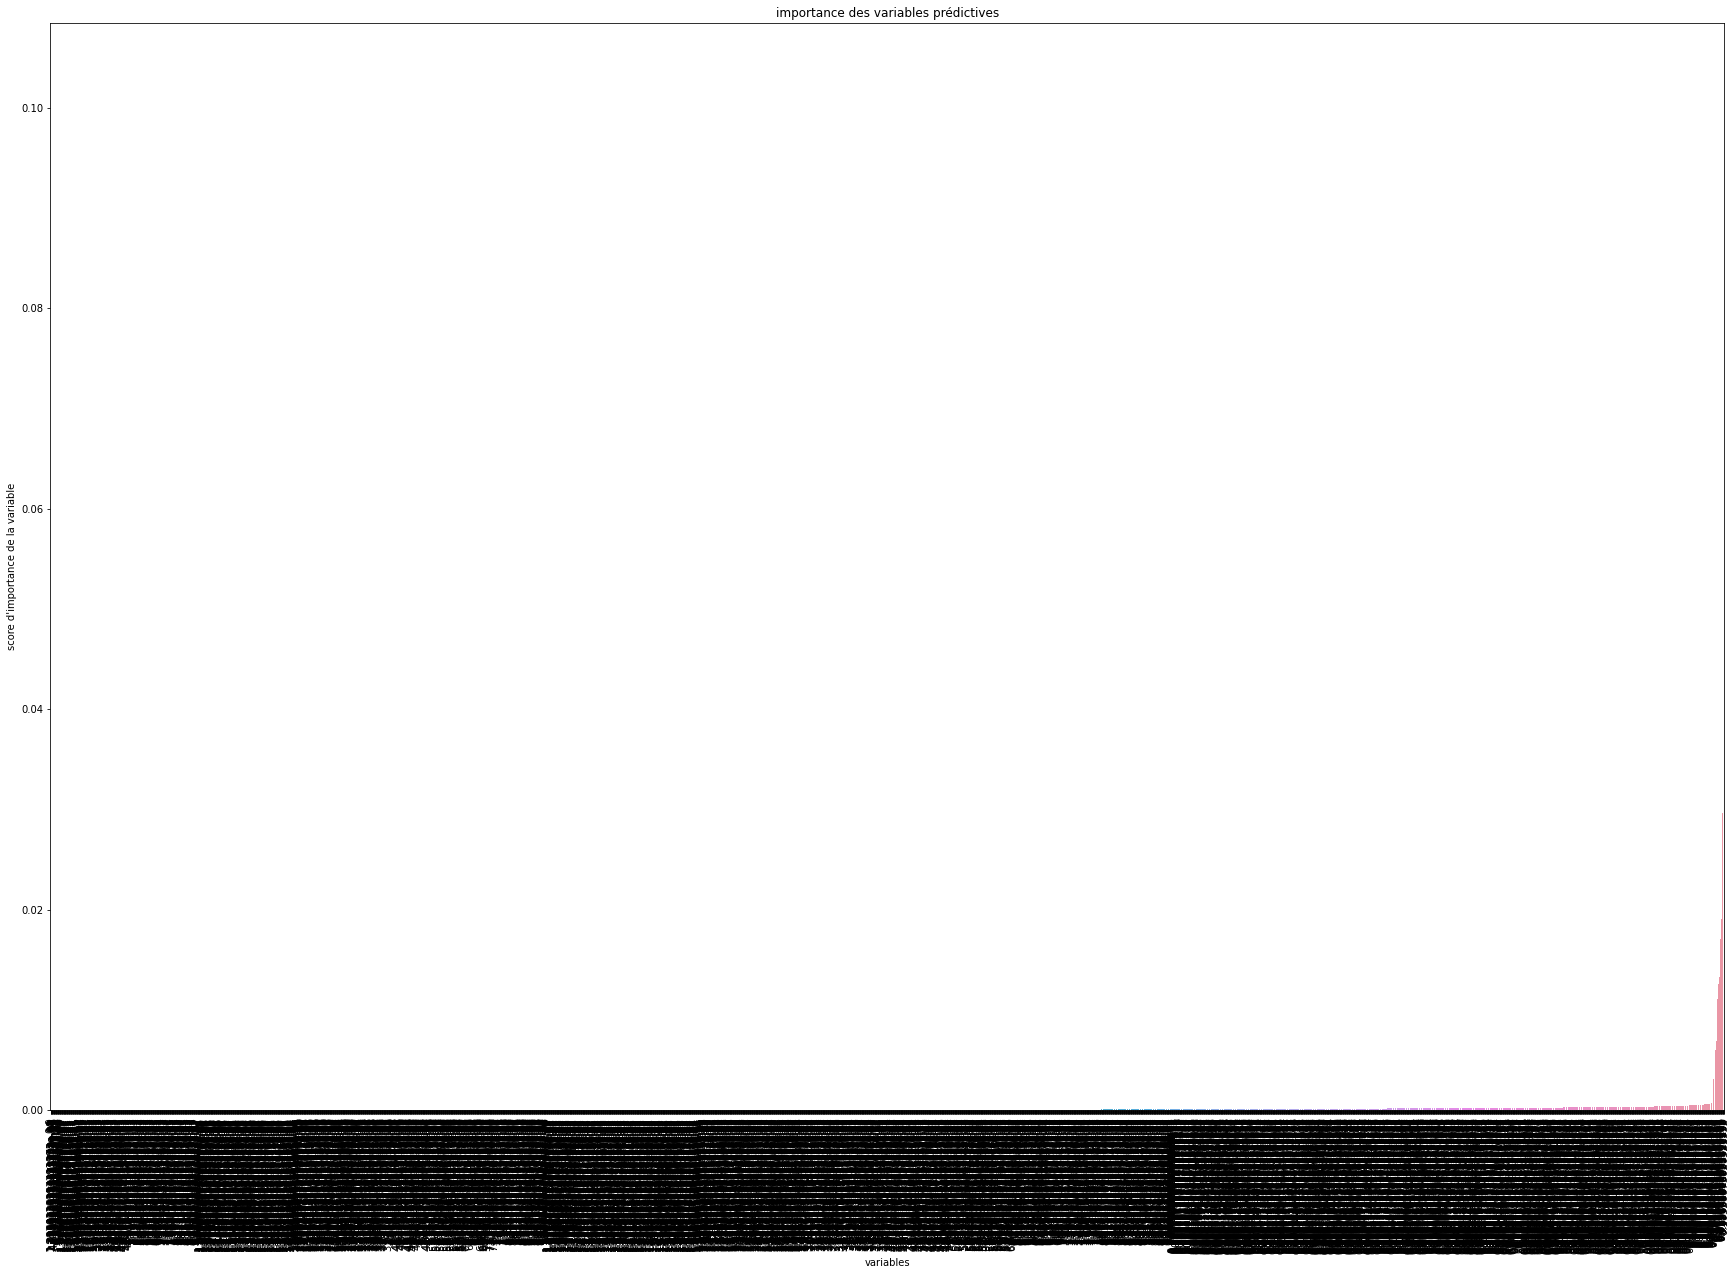

In [ ]:
plt.figure(figsize=(30,20))
plt.xticks(rotation=90)
sns.barplot(x=vars_imp, y=vars_imp)
plt.xlabel("variables")
plt.ylabel("score d'importance de la variable")
plt.title("importance des variables prédictives")
plt.show()

In [ ]:
#affichage  de vars_imp
vars_imp

tenure                             0.000000
gender                             0.000000
TotalCharges                       0.014758
TechSupport_Yes                    0.012590
TechSupport_No internet service    0.003675
                                     ...   
0013-MHZWF                         0.000022
0013-EXCHZ                         0.000131
0011-IGKFF                         0.000000
0004-TLHLJ                         0.000000
0003-MKNFE                         0.000014
Length: 7061, dtype: float64

In [ ]:
#variables selectionnées pour les algorithmes
seuil=0.004
vars_selected=vars_imp[vars_imp>seuil].index.to_list()
train_features=train_features[vars_selected]
X_val=X_val[vars_selected]
X_test=X_test[vars_selected]


In [ ]:
#nombre des variables prédictrices

len(vars_selected)
len(train_features)

4219

***Modélisation***

In [ ]:
#Rgression Logistique
#Dictionnaire des hyperparamètres
param_grid={'c':[0.001,0.01,1,10,50,100,500]}


In [ ]:
#Objet GridSearchCV
rl_cv_class=GridSearchCV(estimator=LogisticRegression(random_state=seed,max_iter=500),param_grid=param_grid,scoring='f1',cv=5)

In [ ]:
#Entrainement de l'algo.fit(train_features, train_labels)
rl_cv_class.fit(train_features,train_labels)

In [ ]:
#meilleur score et meilleur hyperaparamètre
print(rl_cv.best_score_)
print(rl_cv.best_estimator_)

In [ ]:
#fonction d'évalation de la performance du modèle
def model_evaluation(model,features,labels):
   pred=model.predict(features)
   print(classification_report(labels,pred))

In [ ]:
#évalation du modèle de regression logistique
model_evaluation(rl_cv,X_val,y_val)

In [ ]:
#Création d'une fonction de construction d'un modèle avec utilisation de l'algo RFE
def model_with_rfe(model):
  rfe_model=RFE(estimator=model,verbose=0)
  rfe_model=.fit(train_features,train_labels)
  mask=rfe_model.support_
  reduce_X=train_features.loc[:,mask]
  print(reduced_X.columns)
  return rfe_model  

In [ ]:
#Logistique regression RFE
rfe_model=model_with_rfe(rl_cv.best_estimator_)
rfe_model

In [ ]:
#Evaluation du modèle  de regression logistique
model_evalation(rfe_model,X_val,y_val)

*ici RFE réduit les nombres des predicteurs  de 28 à 14 mais n'améliore pas la performance du modèle.*

In [ ]:
#Forêt aléatoire
#Dictionnaire des hyperparamètres
param_grid_rf={'n_estimator':[10,50,100,500,1000],'max_depth':[3,5,10,20,None]}
#Objet GridSearchCV
grid_rf_class=GridSearchCV(estimator=RandomForestClassifier(random_state=seed),
                           param_grid_rf=param_grid_rf,
                           scoring='f1',cv=5)

In [ ]:
#Entrainement de l'algo
rf_model=grid_rf_class.fit(train_features,train_labels)

In [ ]:
#meilleur score et meilleur hyperaparamètre
print(round(rf_model_model.best_score_,3))
print(rf_model.best_estimator_)

**Comparé au modèle de logistique de regression, la forêt aléatoire seomble moins efficace.**

In [ ]:
#Random Forest avec RFE
rfe_forest_model=model_with_rfe(rf_model.best_estimator_)
rfe_forest_model

In [ ]:
#Evaluation du modèle  de forêt aléatoire avec RFE
model_evalation(rfe_forest_model,X_val,y_val)

***Classificateur Perceptron  multicouche**

In [ ]:
#MLPClassifier
mlp=MLPClassifier(random_state=seed,max_iter=1000)
parameters= {'hidden_layer_sizes':[(50,),(100,),(200,)],
            #'activation':['identity’, ‘logistic’, ‘tanh’, ‘relu'],
            #'learning_rate':[‘constant’, ‘invscaling’, ‘adaptive’]
            }
mlp_cv=GridSearchCV(mlp,parameters,scoring='f1',cv=5,n_jobs=-1)
mlp_cv.fit(train_features,train_labels)

In [ ]:
#meilleur score et meilleur hyperparametres
#round(mlp_cv.best_score_,3)
mlp_cv.best_estimator_

In [ ]:
#évaluation du modèle Perceptron
model_evaluation(mlp_cv,X_val, y_val)

***Support vector machine***

In [ ]:
#support vector machine:classificateur qui trouve l'hyperplan optimal qui maximise la frontière entre deux classes
svm_model=SVC(random_state=seed)
svm_hyp={'kernel':['linear','rbf'],'C':[0.1,1.0,10,50,100]}
svm_cv=GridSearchCV(svm_model,svm_hyp,scoring='f1',cv=5)

In [ ]:
#évaluation du modèle SVM
evaluation_model(svm_cv.best_estimator_,X_val,y_val)

***Conclusion***

*Nous avons utilisé les données d'évaluation pour selectionner le meilleur modèle.Ensuite, nous avons évalué le meilleur modèle selectionné pour les données de test afin d'apprécier sa performance sur de nouvelles données. Idéalement, les performances de ce modèle sur les données d'évaluation  et sur les données de test doivent relativement être proches.*

In [ ]:
#Performance du meilleur modèle sur les données de test
model_evaluation(logreg_model.best_estimator_,X_test,y_test)